# Visualization Experiments

Lets load the data artefacts to local memory. These files are to be downloaded from S3 as the pipeline automatically uploads them to the pre-configured S3 bucket.

In [24]:
from file_util import download_files
import pickle

# Download files from S3 bucket. You can download multiple files at a time by passing a list of names
files_to_download = ["df.pkl", "mappings.pkl", 'transcript_timestamps.txt']
download_files(files_to_download)

2023-06-14 23:48:05.490 | INFO     | file_util:download_files:36 - Downloading file df.pkl
2023-06-14 23:48:07.270 | INFO     | file_util:download_files:36 - Downloading file mappings.pkl
2023-06-14 23:48:07.756 | INFO     | file_util:download_files:36 - Downloading file transcript_timestamps.txt


In [ ]:
# Download spacy model for the first time
!spacy download en_core_web_md


In [25]:
import spacy

spaCy_model = "en_core_web_md"
nlp = spacy.load(spaCy_model)
stopwords = nlp.Defaults.stop_words


## Example template 1

## Scatter plot of transcription with Topic modelling

Change the values of "category", "category_name" to one agenda topic and change the value of "not_category_name" and see different plots.

In [27]:
import pandas as pd
import scattertext as st

df = pd.read_pickle("df.pkl")

def plot_topic_modelling_and_word_to_sentence_search(df, cat_1, cat_1_name, cat_2_name):
    df = df.assign(parse=lambda df: df.text.apply(st.whitespace_nlp_with_sentences))

    corpus = st.CorpusFromParsedDocuments(
        df, category_col='ts_to_topic_mapping_top_1', parsed_col='parse'
    ).build().get_unigram_corpus().remove_terms(stopwords, ignore_absences=True).compact(st.AssociationCompactor(2000))
    
    html = st.produce_scattertext_explorer(
        corpus,
        category=cat_1, category_name=cat_1_name, not_category_name=cat_2_name,
        minimum_term_frequency=0, pmi_threshold_coefficient=0,
        width_in_pixels=1000,
        transform=st.Scalers.dense_rank
    )
    open('./demo_compact.html', 'w').write(html)

plot_topic_modelling_and_word_to_sentence_search(df,
                                                cat_1="Workforce",
                                                cat_1_name="Workforce",
                                                cat_2_name="Enablement")

# once you are done, check the generated HTML file


## Example template 2

## Time driven Insights

In [34]:
mappings = pickle.load(open("mappings.pkl", "rb"))
timestamp_to_topic_first_match = mappings[0]
timestamp_to_topic_second_match = mappings[1]
topic_to_timestamp_first_match = mappings[2]
topic_to_timestamp_second_match = mappings[3]

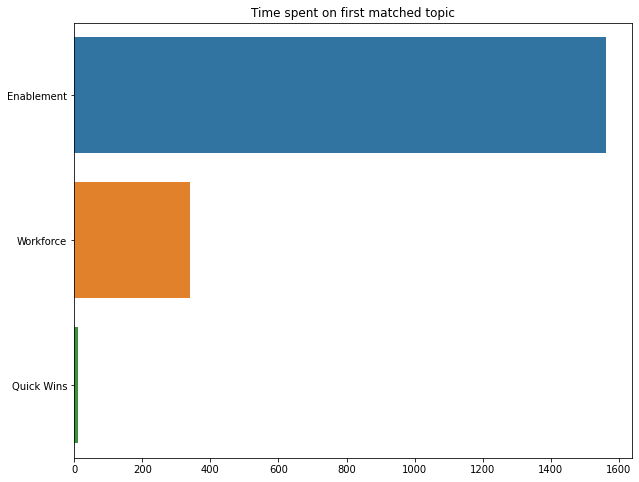

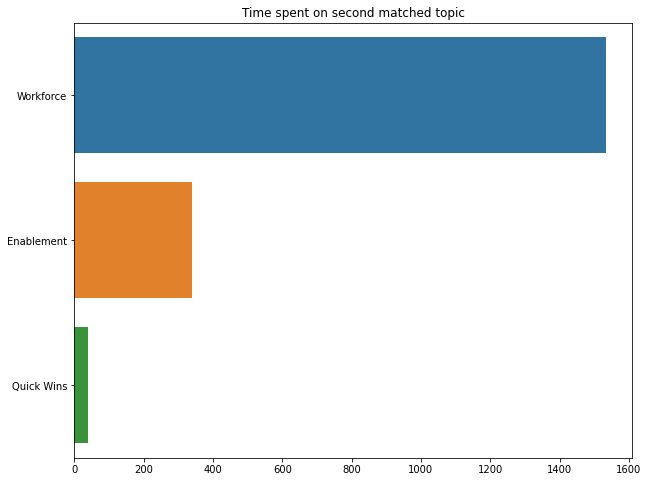

In [35]:
import collections 
import seaborn as sns
import matplotlib.pyplot as plt

def plot_time_spent_for_topic(mapping, order):
    topic_times = collections.defaultdict(int)
    for key in mapping.keys():
        if key[1] is None or key[0] is None:
            continue
        duration = key[1] - key[0]
        topic_times[mapping[key]] += duration
    
    keys = list(topic_times.keys())
    vals = [int(topic_times[k]) for k in keys]    
    plt.figure(figsize=(10,8))
    sns.barplot(x=vals, y=keys).set(title='Time spent on ' + order +  ' matched topic')

        

plot_time_spent_for_topic(timestamp_to_topic_first_match, "first")
plot_time_spent_for_topic(timestamp_to_topic_second_match, "second")

## Example template 3

## Enhanced search for timelines

We can already search for a particular word in the interactive HTML document from example 1 to see a list of all transcribed sentences having an occurence of the word (in the context of the chosen topic). 

We can also retrieve all the segments(timestamps)in the transcription, related to a particular topic, to

i) Segregrate all content on a particular topic of importance.

ii) Perform selective summarization of the segregated content to make productive follow-ups. (Maybe use a model to extract action items and announcements from the transcription or selective summary ? )

iii) Use the timestamps to highlight video / audio / transcription segments.

iv) Jump to a desired segment of video / audio / transcription.

In [37]:
def retrieve_time_segments(topic):
    return topic_to_timestamp_first_match[topic]

search_topic = "Enablement"
print("Timelines where " + search_topic + " was covered : ")
time_segments_of_interest = retrieve_time_segments(topic=search_topic)
time_segments_of_interest

Timelines where Enablement was covered : 


[(0.0, 2.0),
 (4.0, 8.0),
 (8.0, 15.0),
 (15.0, 18.0),
 (18.0, 22.0),
 (22.0, 28.88),
 (28.88, 34.08),
 (34.08, 40.56),
 (40.56, 115.0),
 (115.0, 148.08),
 (148.08, 156.56),
 (156.56, 168.0),
 (168.0, 176.0),
 (176.0, 182.0),
 (182.0, 260.0),
 (288.0, 311.0),
 (311.0, 406.0),
 (406.0, 412.56),
 (412.56, 418.08),
 (426.12, 432.56),
 (432.56, 476.0),
 (526.8, 529.6),
 (530.52, 532.0),
 (532.0, 533.72),
 (533.72, 534.76),
 (534.76, 536.56),
 (536.56, 538.8),
 (548.0, 550.0),
 (550.0, 551.0),
 (551.0, 554.0),
 (554.0, 555.0),
 (563.0, 629.2),
 (629.2, 633.04),
 (634.08, 638.4),
 (638.4, 641.76),
 (643.04, 706.76),
 (706.76, 711.66),
 (767.24, 768.84),
 (768.84, 772.24),
 (801.0, 808.0),
 (809.0, 812.0),
 (874.24, 879.84),
 (879.84, 914.0),
 (927.52, 934.68),
 (941.56, 966.44),
 (966.44, 968.64),
 (968.64, 970.96),
 (970.96, 974.48),
 (974.48, 977.8),
 (977.8, 980.88),
 (980.88, 984.44),
 (984.44, 1049.0),
 (1049.0, 1061.0),
 (1061.0, 1072.0),
 (1072.0, 1079.0),
 (1079.0, 1107.0),
 (1107.0,

## Selective segregation of content

In [38]:
import json
import ast

time_segments_of_interest = retrieve_time_segments("Enablement")

ts_transcript = {}
with open("transcript_timestamps.txt", "r") as f:
    ts_transcript = f.read()
ts_transcript = ast.literal_eval(ts_transcript)

selective_transcribed_content = ""
for chunk in ts_transcript["chunks"]:
    if chunk["timestamp"] in time_segments_of_interest:
        selective_transcribed_content += chunk["text"]

In [39]:
selective_transcribed_content

" So everything's going well so far. I'm going to join us. This is where you keep this low key. Very casual. Absolutely. All right. Well, thank you all for being here. We're very honored that you came to join us for this conversation. We are going to spend a little bit of time. I know it was written up, right? But thinking about how you actually grow and retain your employees, we know that there's a war on talent, especially in the cyberspace right now, right? Everybody's trying to get everybody in the door. Type lines are a little bit dry, a little bit hard to find. It's a tricky scenario. What we want to do if you allow us for this session is to almost park that call to the site. We're just going to spend just leaving for the moment. We're just going to put that aside. And instead, what we're going to focus on, or the employees that you actually have on board, already. We know that the hiring piece is complex. It requires dollars and HR and a whole bunch of stuff. That's that. We're 

## Selective topic summarization

We can use this selective content to now summarize using the already available pipeline !

# And Much More !!